## Tension Calibration

Here I will use the Planck fiducial cosmology and LSST covariance to generate data vectors near the Planck cosmology.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib notebook

In [3]:
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/tension_calibration/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

In [4]:
lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

In [5]:
noise_dist = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=fid, covariance_matrix=cov
)

In [6]:
n_samples = 10000

data_set = np.array([noise_dist.sample() for i in range(n_samples)])

/home/grads/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/grads/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we ca

In [7]:
chisq = np.zeros(n_samples)

inv_cov = torch.inverse(cov)
for i in range(n_samples):
    data_vec = data_set[i]-fid
    data_vec_T = np.transpose(data_vec)
    chi2 = np.matmul(data_vec_T,np.matmul(inv_cov,data_vec))
    chisq[i]=chi2

<IPython.core.display.Javascript object>


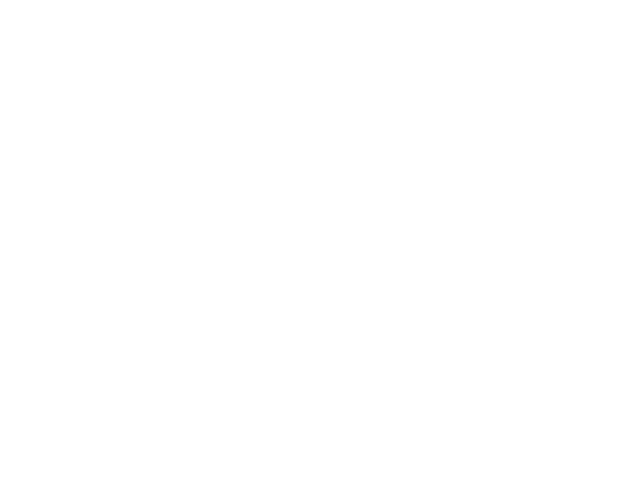

In [8]:
plt.ion()
plt.xlabel('$\chi^2$')
plt.hist(chisq,bins=np.arange(0,np.amax(chisq))+1)
plt.show()
#print(chisq)

Removed no burn in
[array([1503.86181641, 1616.71862793]), array([1450.81970215, 1673.06677246]), array([1393.90808105, 1727.49743652]), array([1344.57214355, 1803.41479492])]


<IPython.core.display.Javascript object>


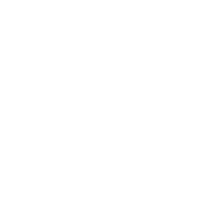

In [9]:
chain = MCSamples(samples=chisq,names=['chisq'])
ttlim = [0.6827,0.9545,0.9973,1]
limits = []
for lim in ttlim:
    limits.append(chain.twoTailLimits(0,lim))
print(limits)

g = plots.get_subplot_plotter()
g.plot_1d(chain, param='chisq',filled=False,lims=[0,np.amax(chisq)+1])

In [10]:
indices = []
for i in range(0,len(limits)):
    indices.append(np.where((chisq > limits[i][0]) 
                            & (chisq < limits[i][1])))
    
#print(indices)
for i in range(len(indices)):
    print(indices[i][0])
    print(len(indices[i][0]))

[   0    2    3 ... 9995 9997 9999]
6826
[   0    1    2 ... 9997 9998 9999]
9544
[   0    1    2 ... 9997 9998 9999]
9972
[   0    1    2 ... 9997 9998 9999]
9998


In [20]:
filtered_ids = [indices[0][0]]
for i in range(len(indices)-1):
    level_1 = indices[i][0]
    level_2 = indices[i+1][0]
    
    for idx in level_1:
        level_2 = level_2[level_2 != idx]
    print(level_1)
    print(level_2)
    filtered_ids.append(level_2)
print('\n\n')
print(filtered_ids[2])
print(filtered_ids[3])

#for i in range(len(filtered_ids)):
    #print(filtered_ids[i])
    #print(len(filtered_ids[i]))


[   0    2    3 ... 9995 9997 9999]
[   1    4    9 ... 9989 9996 9998]
[   0    1    2 ... 9997 9998 9999]
[   5    7    8   49   69   80   90   98  103  108  148  160  209  287
  312  313  334  376  389  409  412  415  439  450  475  500  512  553
  588  619  631  657  663  676  689  700  722  760  771  794  850  867
  882  886  907  952  956  999 1042 1070 1103 1121 1126 1149 1154 1166
 1188 1273 1279 1285 1327 1338 1363 1377 1400 1412 1418 1440 1470 1529
 1546 1550 1662 1700 1715 1729 1763 1793 1810 1816 1835 1854 1855 1857
 1861 1940 1948 1949 1988 2025 2041 2098 2160 2165 2256 2271 2278 2318
 2328 2334 2362 2392 2402 2407 2432 2438 2443 2498 2523 2531 2532 2602
 2615 2670 2675 2691 2731 2737 2790 2825 2837 2905 2923 2930 2937 2991
 3037 3088 3092 3098 3138 3186 3208 3226 3239 3245 3247 3256 3314 3345
 3357 3359 3399 3405 3432 3444 3466 3477 3480 3492 3525 3553 3558 3560
 3571 3579 3598 3623 3624 3707 3725 3829 3846 3872 3892 3934 3937 3944
 4042 4068 4136 4137 4151 4155 4170 4192

In [23]:
_savedir = '/home/grads/data/evan/tension_calibration/dvs/'
# Now I want to save each of the data vectors in csv format
for i in range(len(ttlim)):
    print(ttlim[i])
    _dv = []
    
    # uncomment this if you want to save ALL data vectors
    ########
    #for j in filtered_ids[0]:
    #    _dv.append(data_set[j].numpy())
    ########
    
    # uncomment to save N random data vectors
    ########
    N=20
    ids = np.arange(len(filtered_ids[i]))
    print(ids)
    np.random.shuffle(ids)
    print(ids)
    ids = ids[:N]
    print(ids)
    idx = [filtered_ids[i][ids[j]] for j in range(N)]
    ########
    
    _dv = [data_set[idx[j]].numpy() for j in range(N)]
    
    np.savetxt(_savedir+"noisy_dv_"+str(ttlim[i])+'.csv', np.array(_dv), delimiter=",")
print('Data vectors save in: '+_savedir)

0.6827
[   0    1    2 ... 6823 6824 6825]
[6285 3259 2145 ... 4059 4948 4651]
[6285 3259 2145 5460 6144 5653 6365 2502 5116 2476 2884  685  381  735
 2465 2919 2636 1074 1160 1144]
0.9545
[   0    1    2 ... 2715 2716 2717]
[2683  543  893 ... 2145  492  739]
[2683  543  893 1169 1629  512 1625  729 2174  352 1332  635  505  319
  165 1514  811  877 2307  986]
0.9973
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 